In [ ]:
# Timestep convergence test with the same spatial resolution (coarse mesh: refine_level=1) and different timestep length
# plot the convergence curve: F-distance vs timestep length

# created by peng zhai in Jun 4th, 2025
import subprocess
import os
import time
import h5py
import numpy as np
import copy
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# 200 s
def execute_and_log_command(command, log_file):
    with open(log_file, 'w') as log:
        log.write(f"Executing: {command}\n")
        try:
            result = subprocess.run(command, shell=True, check=True, text=True, capture_output=True)
            
            # Log the output and errors
            log.write("Output:\n")
            log.write(result.stdout)
            log.write("Error (if any):\n")
            log.write(result.stderr)
        except subprocess.CalledProcessError as e:
            # Log the error details
            log.write(f"An error occurred while executing: {command}\n")
            log.write(f"Return Code: {e.returncode}\n")
            log.write("Output:\n")
            log.write(e.stdout)
            log.write("Error Message:\n")
            log.write(e.stderr)
        
        log.write('-' * 40 + '\n')  # Separator for readability

def frobenius_distance(matrix1, matrix2):
    """Calculates the Frobenius norm distance between two matrices."""
    matrix1 = np.array(matrix1)
    matrix2 = np.array(matrix2)
    if matrix1.shape != matrix2.shape:
      raise ValueError("Matrices must have the same shape")
    
    diff = matrix1 - matrix2
    distance = np.linalg.norm(diff, 'fro')
    return distance    

In [69]:
# def main():

start_time = time.perf_counter()

log_view_dir = 'perf_ts'
os.makedirs(log_view_dir, exist_ok=True)
# List of Linux commands to execute

# Create a directory for logs if it doesn't exist
log_screen_dir = 'command_logs_constant_ts'
os.makedirs(log_screen_dir, exist_ok=True)

# the default solver is euler without adaptive timesteps
# the first one has the highest resolution

timestep = 10**np.arange(-1,2, 0.5)
print(timestep)
commands = []

for i in range(len(timestep)):
    commands.append("pylith step01a_slip_ts.cfg --timedependent.initial_dt="+ str(timestep[i]) +"*year --timedependent.start_time=-"+ str(timestep[i]) +"*year --petsc.log_view=ascii:./" + log_view_dir + "/" + str(i+1) +".txt", )

print(commands)

# commands = [

#     "pylith step01a_slip_ts.cfg --timedependent.initial_dt=0.05*year --timedependent.start_time=-0.2*year --petsc.log_view=ascii:./" + log_view_dir + "/1.txt",  
#     "pylith step01a_slip_ts.cfg --timedependent.initial_dt=0.2*year --timedependent.start_time=-0.2*year --petsc.log_view=ascii:./" + log_view_dir + "/2.txt",  
#     "pylith step01a_slip_ts.cfg --timedependent.initial_dt=1.0*year --timedependent.start_time=-1.0*year --petsc.log_view=ascii:./" + log_view_dir + "/3.txt",  
#     "pylith step01a_slip_ts.cfg --timedependent.initial_dt=5.0*year --timedependent.start_time=-5.0*year --petsc.log_view=ascii:./" + log_view_dir + "/4.txt",  
#     "pylith step01a_slip_ts.cfg --timedependent.initial_dt=10.0*year --timedependent.start_time=-10.0*year --petsc.log_view=ascii:./" + log_view_dir + "/5.txt",  

# ]

# Execute each command and log to separate files

# # load the baseline data (high resolution)
# filename = "output_baseline_convergece/step01a_slip_ts-domain.h5"
# with h5py.File(filename, "r") as f:

#     vertex_fields = list(f.keys())[2]

#     displacement = list(f[vertex_fields])[0]    # data name in the group
#     data_tmp = f[vertex_fields][displacement]
#     data_baseline = np.squeeze(data_tmp[-1,:,:])

#     # print(f'Baseline model: Total timestep:', {data_baseline.shape[0]}, 'Total nodes' , {data_baseline.shape[1]},'d.o.f.' , {data_baseline.shape[2]} ) 

#     # spatial location
#     geometry = list(f.keys())[0]
#     vertices = list(f[geometry])[0]    # data name in the group
#     xz_baseline_tmp = f[geometry][vertices]  # 2*2
#     xz_baseline = xz_baseline_tmp[:,:]


[ 0.1         0.31622777  1.          3.16227766 10.         31.6227766 ]
['pylith step01a_slip_ts.cfg --timedependent.initial_dt=0.1*year --timedependent.start_time=-0.1*year --petsc.log_view=ascii:./perf_ts/1.txt', 'pylith step01a_slip_ts.cfg --timedependent.initial_dt=0.31622776601683794*year --timedependent.start_time=-0.31622776601683794*year --petsc.log_view=ascii:./perf_ts/2.txt', 'pylith step01a_slip_ts.cfg --timedependent.initial_dt=1.0*year --timedependent.start_time=-1.0*year --petsc.log_view=ascii:./perf_ts/3.txt', 'pylith step01a_slip_ts.cfg --timedependent.initial_dt=3.1622776601683795*year --timedependent.start_time=-3.1622776601683795*year --petsc.log_view=ascii:./perf_ts/4.txt', 'pylith step01a_slip_ts.cfg --timedependent.initial_dt=10.0*year --timedependent.start_time=-10.0*year --petsc.log_view=ascii:./perf_ts/5.txt', 'pylith step01a_slip_ts.cfg --timedependent.initial_dt=31.622776601683793*year --timedependent.start_time=-31.622776601683793*year --petsc.log_view=asc

In [ ]:
N = len(commands)
distance = np.zeros(N)

for i, command in enumerate(commands, 1):
    log_file = os.path.join(log_screen_dir, f"command_log_{i}.txt")
    print(command)
    execute_and_log_command(command, log_file)
        
    filename = "output/step01a_slip_ts-domain.h5"
    
    with h5py.File(filename, "r") as f:
        # Print all root level object names (aka keys) 
        # these can be group or dataset names 
        # print("Keys: %s" % f.keys())
        # get first object name/key; may or may NOT be a group
        vertex_fields = list(f.keys())[2]
        displacement = list(f[vertex_fields])[0]    # data name in the group
        data_tmp = f[vertex_fields][displacement]
        data = np.squeeze(data_tmp[-1,:,:])    # 2D 
        # print(f'Total timestep:', {data.shape[0]}, 'Total nodes' , {data.shape[1]},'d.o.f.' , {data.shape[2]} ) 
        # print(data.dtype)
        # spatial location
        geometry = list(f.keys())[0]
        vertices = list(f[geometry])[0]    # data name in the group
        xz_tmp = f[geometry][vertices]      # 2D  
        xz = xz_tmp[:,:]

    if i == 1:     # save the baseline model
        data_baseline = data
    else:       # compare other low-res results with the baseline model of high resolution
        # print(xz.dtype)
        # upsampling (interpolation) the final solution field to the high res results
        # data -> data_upsample   
        # data_upsample = data_upsample_tmp[:,:]

        # data_upsample_x = griddata(xz, data[:,0], xz_baseline, method='cubic')
        # data_upsample_y = griddata(xz, data[:,1], xz_baseline, method='cubic')
        # # print(data_upsample_x.shape)
        # # print(data_upsample_y.shape)

        # data_upsample = np.vstack((data_upsample_x, data_upsample_y)).T     # 12298*2

        # print(data_upsample.shape)
        distance[i-1] = frobenius_distance(data_baseline, data)
                        
print("The frobenius-distance is: " + str(distance))
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")
print(f"Commands have been executed and logs are saved in '{log_screen_dir}' directory")



pylith step01a_slip_ts.cfg --timedependent.initial_dt=0.1*year --timedependent.start_time=-0.1*year --petsc.log_view=ascii:./perf_ts/1.txt


KeyboardInterrupt: 

/tmp/ipykernel_18902/903389723.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


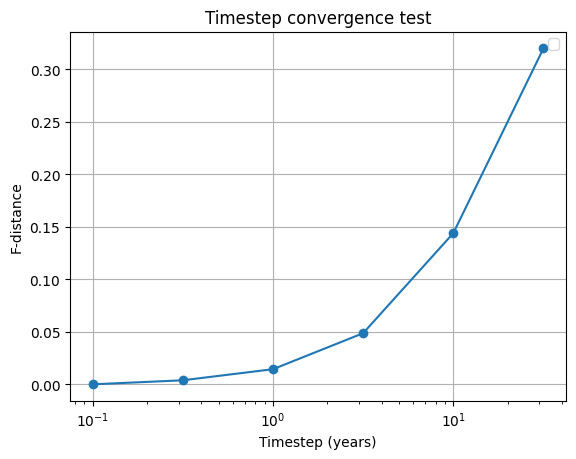

In [ ]:
np.save('distance_time_convergence.npy', timestep, distance)

# Data for plotting
fig, ax = plt.subplots()
ax.plot(timestep, distance, marker="o")

ax.set(xlabel='Timestep (years)', ylabel='F-distance', title='Timestep convergence test')
ax.set_xscale('log')

ax.legend()
ax.grid()

# fig.savefig("test.png")
plt.show()